In [95]:
import numpy as np
import pandas as pd

from sklearn.externals.six import StringIO 

from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR

from sklearn.metrics import *

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
%matplotlib inline 
sns.set(style="ticks")

In [96]:
wine = load_wine()

In [97]:
wine_df = pd.DataFrame(data=np.c_[wine['data'], wine['target']],
                       columns=list(wine['feature_names']) + ['target'])

In [98]:
# Проверка на пропуски
wine_df.isnull().sum()

# пропусков нет, категориальный признаков тоже нет - кодировать не надо

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [99]:
wine_df.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                          float64
dtype: object

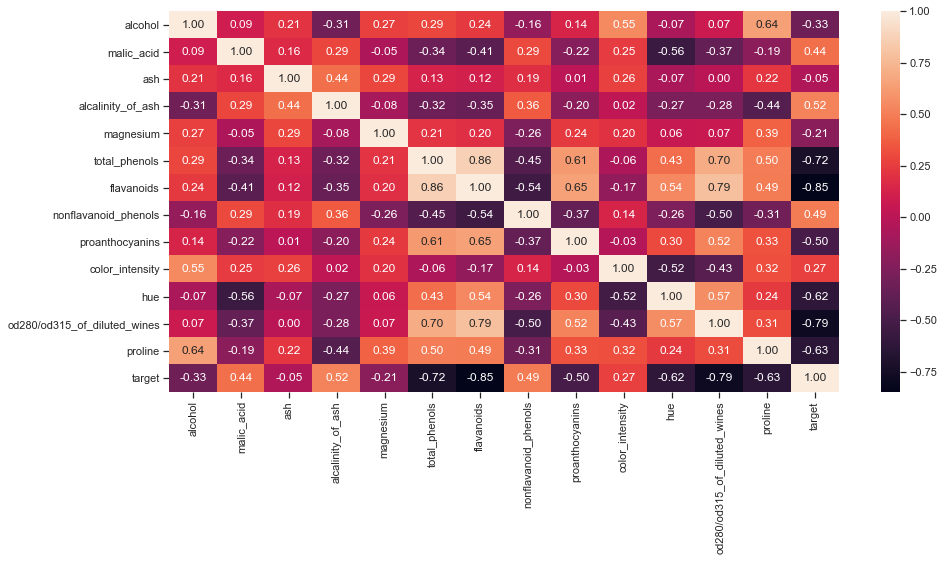

In [100]:
# Построение корреляционной матрицы
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(wine_df.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

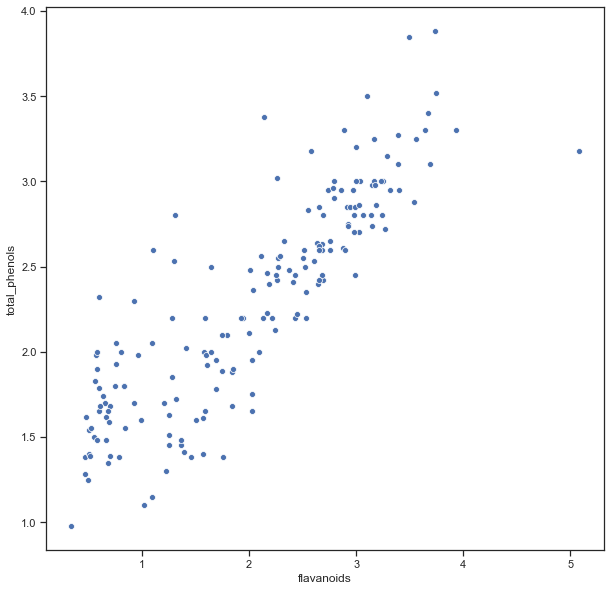

In [101]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(ax=ax, x='flavanoids', y='total_phenols', data=wine_df)

# между признаками существует зависимость близкая к линейной, коэф корреляции = 0.86 

#### Разделение на обучающую и тестовую выборки

In [102]:
X = wine_df['flavanoids'].values.reshape(-1,1)
Y = wine_df['total_phenols'].values.reshape(-1,1)

In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.3, random_state=1)

In [104]:
# Размер обучающей выборки
X_train.shape, Y_train.shape

((124, 1), (124, 1))

In [105]:
# Размер тестовой выборки
X_test.shape, Y_test.shape

((54, 1), (54, 1))

## Линейная модель

#### Аналитически

In [106]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [107]:
b0, b1 = analytic_regr_coef(X_train, Y_train)
b0, b1

(1.175712391016211, 0.5463301350809715)

In [108]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [109]:
y_array_regr = y_regr(X_train, b0, b1)

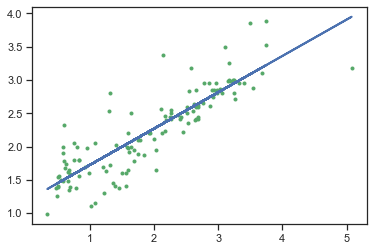

In [110]:
plt.plot(X_train, Y_train, 'g.')
plt.plot(X_train, y_array_regr, 'b', linewidth=2.0)
plt.show()

#### Использование класса LinearRegression библиотеки scikit-learn

In [111]:
# Обучение линейной регрессии и сравнение коэффициентов с рассчитанными ранее
reg1 = LinearRegression().fit(X_train, Y_train)
(b1, reg1.coef_), (b0, reg1.intercept_)

((0.5463301350809715, array([[0.54633014]])),
 (1.175712391016211, array([1.17571239])))

In [112]:
Y_pred = reg1.predict(X_test)

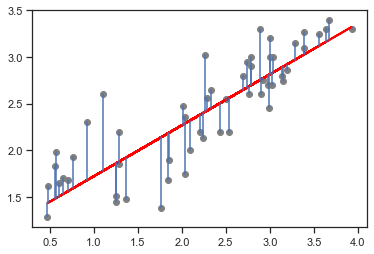

In [113]:
# Прогноз и тестовые данные, показаны ошибки между 
# истинными и предсказанными значениями

plt.scatter(X_test, Y_test,  color='gray')
plt.plot(X_test, Y_pred, color='red', linewidth=2)

for i in range(len(X_test)):
    x1 = X_test[i]
    y1 = Y_test[i]
    y2 = Y_pred[i]
    plt.plot([x1,x1],[y1,y2],'b-')

plt.show()

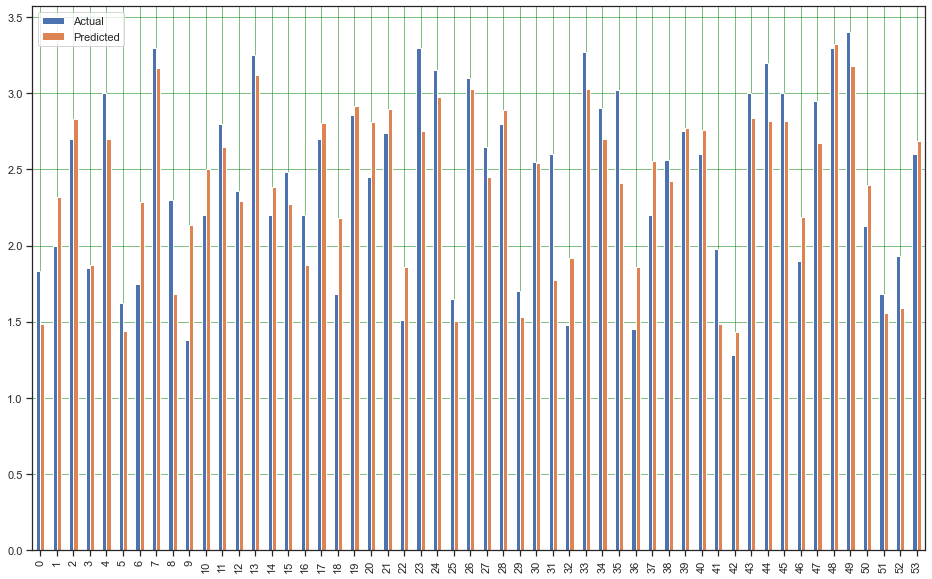

In [114]:
# Гистограмма, показывающая сравнение фактических и прогнозируемых значений

df = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': Y_pred.flatten()})

df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [115]:
# Точность модели
reg1.score(X_test, Y_test)

0.7168117750288533

## SVC

In [116]:
wine_X = wine.data[:, :2]
wine_y = wine.target

In [117]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(wine_X, wine_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = wine_X[:, 0], wine_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('flavanoids')
    ax.set_ylabel('total_phenols')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [118]:
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine.data, wine.target, 
                                                                        test_size=0.3, random_state=1)

In [119]:
svc = SVC(C=1.0, max_iter=10000, gamma=0.2, degree=4, kernel="poly").fit(wine_X_train, wine_y_train)
svc_pred = svc.predict(wine_X_test)

c:\users\administrator\pycharmprojects\rk_tmm\venv\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


c:\users\administrator\pycharmprojects\rk_tmm\venv\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


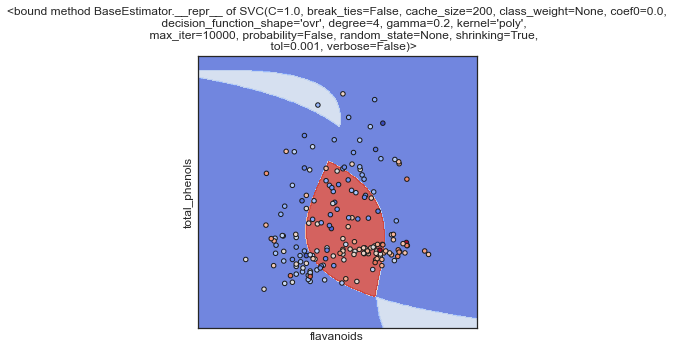

In [120]:
plot_cl(svc)

In [121]:
accuracy_score(wine_y_test, svc_pred)

0.6296296296296297

## Decision Tree

In [122]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))
      

In [123]:
def plot_tree_classification(title_param, ds):
    """
    Построение деревьев и вывод графиков для заданного датасета
    """
    
    n_classes = len(np.unique(ds.target))
    plot_colors = "ryb"
    plot_step = 0.02
    
    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                    [1, 2], [1, 3], [2, 3]]):
        # We only take the two corresponding features
        X = ds.data[:, pair]
        y = ds.target

        # Train
        clf = DecisionTreeClassifier(random_state=1).fit(X, y)

        plt.title(title_param)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))
        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

        plt.xlabel(ds.feature_names[pair[0]])
        plt.ylabel(ds.feature_names[pair[1]])

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color, label=ds.target_names[i],
                        cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

        plt.show() 
        

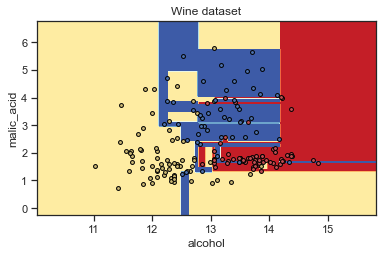

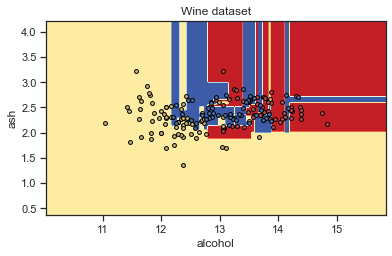

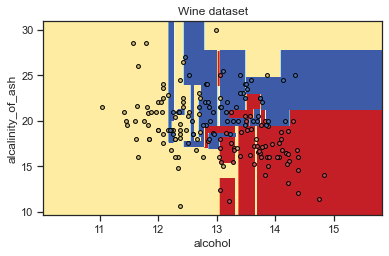

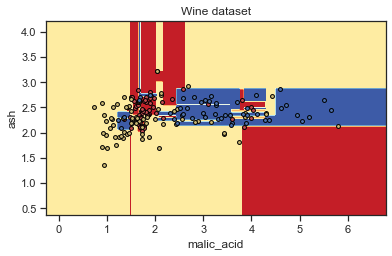

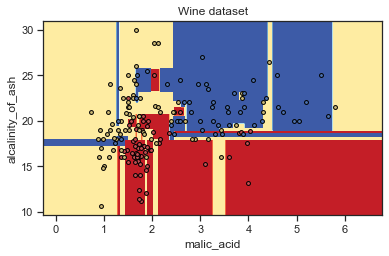

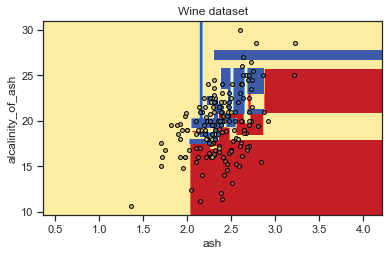

In [124]:
plot_tree_classification('Wine dataset', wine)

In [125]:
wine_x_ds = pd.DataFrame(data=wine['data'], columns=wine['feature_names'])

In [126]:
# Обучим дерево на всех признаках wine
wine_tree_cl = DecisionTreeClassifier(random_state=1)
wine_tree_cl.fit(wine_x_ds, wine.target)
wine_tree_cl

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

Вычисление важности признаков основано на том, какое количество раз признак встречается в условиях дерева.
Чем чаще встречается признак, тем более он важен.


In [127]:
# Важность признаков
list(zip(wine_x_ds.columns.values, wine_tree_cl.feature_importances_))

[('alcohol', 0.012570564071187309),
 ('malic_acid', 0.014223159778821876),
 ('ash', 0.0),
 ('alcalinity_of_ash', 0.0),
 ('magnesium', 0.0534597951279922),
 ('total_phenols', 0.0),
 ('flavanoids', 0.16704836491408806),
 ('nonflavanoid_phenols', 0.0),
 ('proanthocyanins', 0.0),
 ('color_intensity', 0.0),
 ('hue', 0.058185091460406506),
 ('od280/od315_of_diluted_wines', 0.3120425747831769),
 ('proline', 0.38247044986432716)]

In [128]:
# Важность признаков в сумме дает единицу
sum(wine_tree_cl.feature_importances_)

1.0

In [129]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(15,7)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

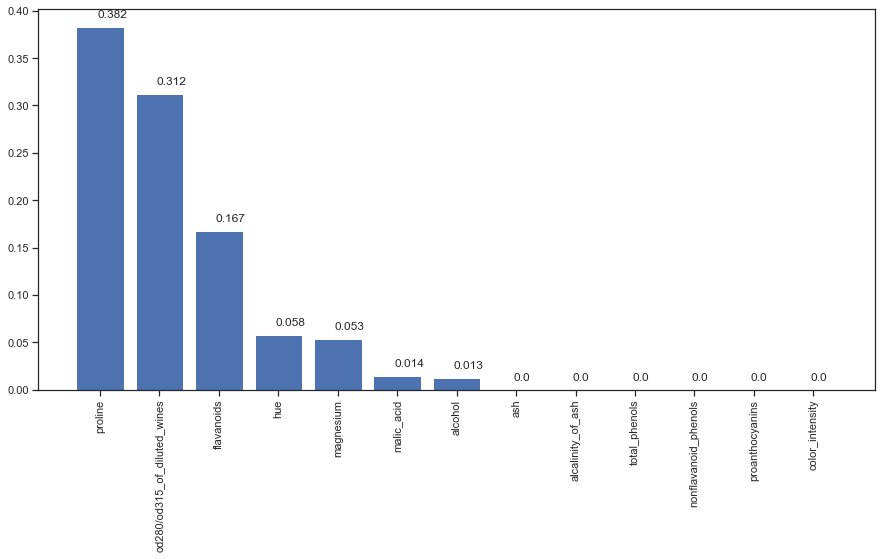

In [130]:
wine_tree_cl_fl, wine_tree_cl_fd = draw_feature_importances(wine_tree_cl, wine_x_ds)

In [131]:
# Список признаков, отсортированный на основе важности, и значения важности
wine_tree_cl_fl, wine_tree_cl_fd

(['proline',
  'od280/od315_of_diluted_wines',
  'flavanoids',
  'hue',
  'magnesium',
  'malic_acid',
  'alcohol',
  'ash',
  'alcalinity_of_ash',
  'total_phenols',
  'nonflavanoid_phenols',
  'proanthocyanins',
  'color_intensity'],
 [0.38247044986432716,
  0.3120425747831769,
  0.16704836491408806,
  0.058185091460406506,
  0.0534597951279922,
  0.014223159778821876,
  0.012570564071187309,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

In [132]:
wine_x_ds.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [133]:
# Пересортируем признаки на основе важности
wine_x_ds_sorted = wine_x_ds[wine_tree_cl_fl]
wine_x_ds_sorted.head()

,proline,od280/od315_of_diluted_wines,flavanoids,hue,magnesium,malic_acid,alcohol,ash,alcalinity_of_ash,total_phenols,nonflavanoid_phenols,proanthocyanins,color_intensity
0,1065.0,3.92,3.06,1.04,127.0,1.71,14.23,2.43,15.6,2.80,0.28,2.29,5.64
1,1050.0,3.40,2.76,1.05,100.0,1.78,13.20,2.14,11.2,2.65,0.26,1.28,4.38
2,1185.0,3.17,3.24,1.03,101.0,2.36,13.16,2.67,18.6,2.80,0.30,2.81,5.68
3,1480.0,3.45,3.49,0.86,113.0,1.95,14.37,2.50,16.8,3.85,0.24,2.18,7.80
4,735.0,2.93,2.69,1.04,118.0,2.59,13.24,2.87,21.0,2.80,0.39,1.82,4.32


In [134]:
# Разделим выборку на обучающую и тестовую
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine_x_ds_sorted, wine.target, test_size=0.5, random_state=1)
wine_X_train.shape, wine_X_test.shape

((89, 13), (89, 13))

In [135]:
# Обучим дерево и предскажем результаты на всех признаках 
wine_tree_cl_feat_1 = DecisionTreeClassifier(random_state=1).fit(wine_X_train, wine_y_train)
wine_y_test_predict = wine_tree_cl_feat_1.predict(wine_X_test)
wine_y_test_predict.shape

(89,)

In [136]:
# Проверим точность по классам
print_accuracy_score_for_classes(wine_y_test, wine_y_test_predict)

Метка 	 Accuracy
0 	 0.9393939393939394
1 	 0.8529411764705882
2 	 0.9545454545454546


In [137]:
# Обучим дерево и предскажем результаты на единственном самом важном признаке 
wine_tree_cl_feat_2 = DecisionTreeClassifier(random_state=1).fit(wine_X_train[[wine_tree_cl_fl[0]]], wine_y_train)
wine_y_test_predict_2 = wine_tree_cl_feat_2.predict(wine_X_test[[wine_tree_cl_fl[0]]])
wine_y_test_predict_2.shape

(89,)

In [138]:
# Проверим точность по классам
print_accuracy_score_for_classes(wine_y_test, wine_y_test_predict_2)

Метка 	 Accuracy
0 	 0.8181818181818182
1 	 0.7352941176470589
2 	 0.36363636363636365
